In [1]:
import cv2
import numpy as np
import pandas as pd
import time
import ast

In [2]:
filename = 'Tracking_Results/trajectories_RawImage_MIL.csv'

In [3]:
''' CONVERSION FROM FORMAT {VORTEX: [[TIME, X, Y],...]} TO FORMAT {TIME: [[VORTEX, X, Y],...]}'''

with open(filename) as f:
    data = f.read()
data = "{" + data + "}"
data_dict = ast.literal_eval(data)

data_for_verification = {}
for vortex_no, data in data_dict.items():
    if len(data) > 1:
        for t, x, y in data:
            if np.round(t, 1) not in data_for_verification.keys():
                data_for_verification[np.round(t, 1)] = []
                data_for_verification[np.round(t, 1)].append([vortex_no, x, y])
            else:
                data_for_verification[np.round(t, 1)].append([vortex_no, x, y])

In [4]:
''' AUTOMATIC START AND END OF VISUALIZATION '''
start = list(data_for_verification.keys())[0]
end = list(data_for_verification.keys())[-1]


start = 35.0
end = 46.0

In [5]:
start_frame_number = round((start-0.1)*10)

# cap = cv2.VideoCapture('Original_Movies/X_phase_velocity_evolution_3_cycles_F=0.06.mkv')
# cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_number)
t = 0.1
t = t * (start_frame_number+1)
previous_vortices = []

''' SAVE TO VIDEO '''
frame_width = 1247
frame_height = 1247
   
size = (frame_width, frame_height)

result = cv2.VideoWriter('TrajectoriesMovementVisualization_RESULTS/trajectories_result.mp4', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

while True:
#     ret, frame = cap.read()
#     roi = frame[149:1396, 104:1351]
    
    roi = np.zeros((frame_height, frame_width), dtype='uint8')
    
    born_vortices = []
    dead_vortices = []
    if t > start+0.1:
        previous_vortices = set(current_vortices.copy())
    
    current_vortices = []
    ''' READING DATA FOR TRACKING '''
    if np.round(t,1) in data_for_verification.keys():
        for vortex, cx, cy in data_for_verification[np.round(t,1)]:
            r = 15
            ''' DISPLAY WITH LOWER BRIGHTNESS PREVIOUS TRAJECTORY POINTS '''
            trajectory = data_dict[vortex]
            time = np.round(t, 1)
            index = trajectory.index([time, cx, cy])
            brightness = 255
            for i in reversed(range(index)):
                brightness -= 35
                if brightness < 30:
                    break
                xx = trajectory[i][1]
                yy = trajectory[i][2]
                xx = int(xx*(1247./817.))
                yy = int(yy*(1247./817.))
                cv2.circle(roi, (xx,yy), r, brightness, cv2.FILLED)
            
            ''' CURRENT VORTEX DISPLAY '''
            cx = int(cx*(1247./817.))
            cy = int(cy*(1247./817.))
            intensity = 255
            cv2.circle(roi, (cx,cy), r, intensity, cv2.FILLED)
            cv2.putText(roi, text= f'{vortex}', org=(cx+r,cy-r),
                fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=255,
                thickness=1, lineType=cv2.LINE_AA)
            current_vortices.append(vortex)

        ''' STATISTICS DISPLAY - (NO OF CURRENT VORTICES, BORN VORTICES, DEAD VORTICES)'''
        no_of_vortices = len(data_for_verification[np.round(t,1)])
        cv2.putText(roi, text= f'NO. OF VORTICES={no_of_vortices}', org=(10,1150),
            fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=255,
            thickness=2, lineType=cv2.LINE_AA)

        if t > start+0.1:
            for vortex in list(previous_vortices.union(set(current_vortices))):
                if vortex in previous_vortices and vortex not in set(current_vortices):
                    dead_vortices.append(vortex)
                elif vortex not in previous_vortices and vortex in set(current_vortices):
                    born_vortices.append(vortex)
            cv2.putText(roi, text= f'BORN: {born_vortices}', org=(10,1190),
                fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=255,
                thickness=1, lineType=cv2.LINE_AA)
            cv2.putText(roi, text= f'DEAD: {dead_vortices}', org=(10,1230),
                fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=255,
                thickness=1, lineType=cv2.LINE_AA)
            width_box = 350
            cv2.rectangle(roi, (5,1115), (width_box, 1240), 255, 2)

    
    ''' TIMESTAMP '''
    cv2.putText(roi, text= f'T={np.round(t, 1)}0', org=(10,40),
        fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.25, color=255,
        thickness=1, lineType=cv2.LINE_AA)
    
    roi = cv2.cvtColor(roi, cv2.COLOR_GRAY2RGB)
    cv2.imshow('Frame', roi)
    
    ''' SAVE MOVIE '''
    result.write(roi)
    
    if t >= end:
        break
    
    t += 0.1

    key = cv2.waitKey(30)
    if key == 27:
        break
        
result.release()
cv2.destroyAllWindows()

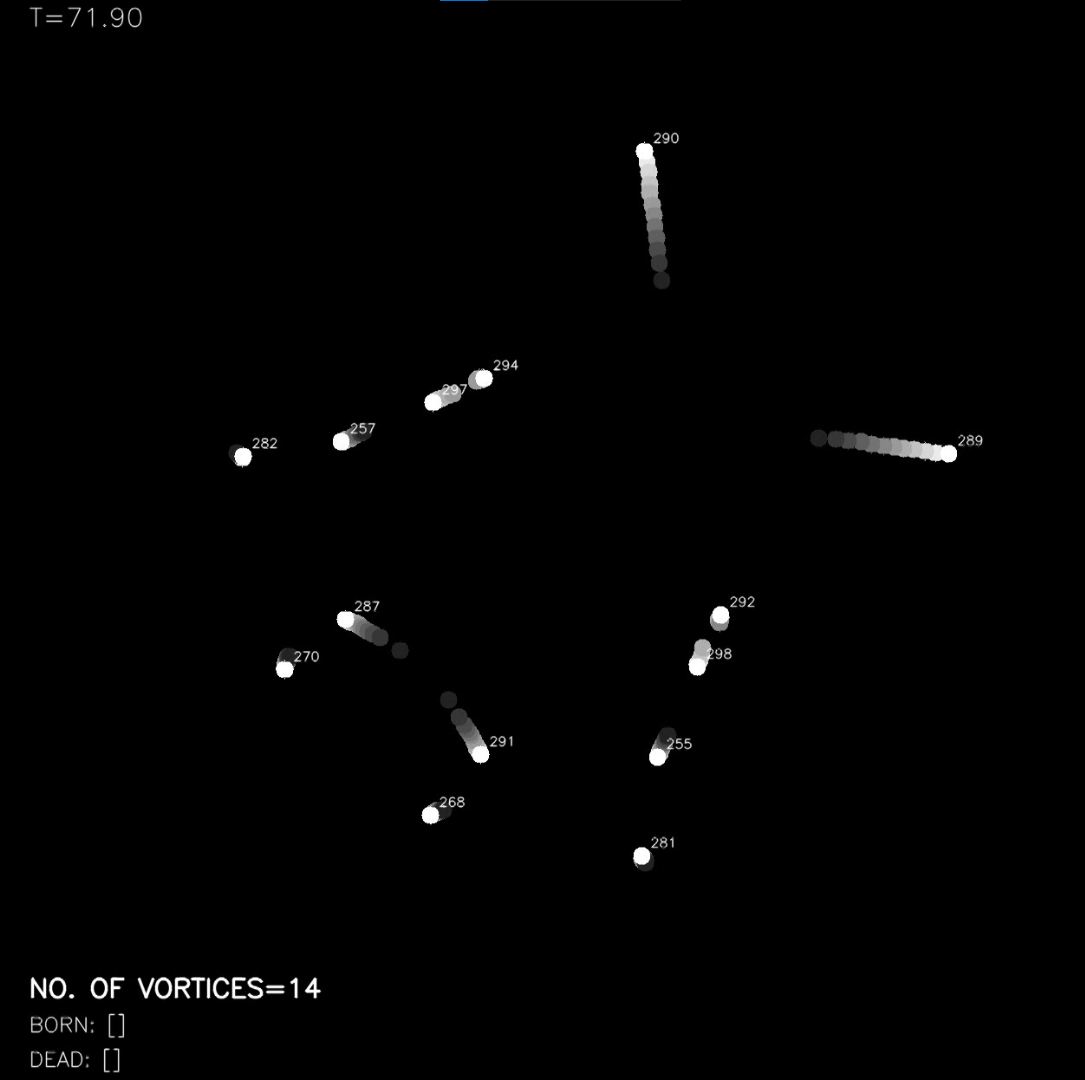